In [12]:
import os
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import random
import math
from scipy.spatial.distance import euclidean, pdist, squareform
import timeit
import time
%matplotlib notebook
import scipy.stats as sts
import multiprocessing as mp
import functools
import matplotlib
from numba import jit

In [15]:
ATOMIC_WEIGHTS = {'H':1.008, 'HE':4.002602, 'LI':6.94, 'BE':9.012182,
       'B':10.81, 'C':12.011, 'N':14.007, 'O':15.999, 'F':18.9984032,
       'NE':20.1797, 'NA':22.98976928, 'MG':24.305, 'AL':26.9815386,
       'SI':28.085, 'P':30.973762, 'S':32.06, 'CL':35.45, 'AR':39.948,
       'K':39.0983, 'CA':40.078, 'SC':44.955912, 'TI':47.867, 'V':50.9415,
       'CR':51.9961, 'MN':54.938045, 'FE':55.845, 'CO':58.933195,
       'NI':58.6934, 'CU':63.546, 'ZN':65.38, 'GA':69.723, 'GE':72.630,
       'AS':74.92160, 'SE':78.96, 'BR':79.904, 'RB':85.4678, 'SR':87.62,
       'Y':88.90585, 'ZR':91.224, 'NB':92.90638, 'MO':95.96, 'TC':98,
       'RU':101.07, 'RH':102.90550, 'PD':106.42, 'AG':107.8682, 'CD':112.411,
       'IN':114.818, 'SN':118.710, 'SB':121.760, 'TE':127.60, 'I':126.90447,
       'XE':131.293, 'CS':132.9054519, 'BA':137.327, 'LA':138.90547,
       'CE':140.116, 'PR':140.90765, 'ND':144.242, 'PM':145, 'SM':150.36,
       'EU':151.964, 'GD':157.25, 'TB':158.92535, 'DY':162.500, 'HO':164.93032,
       'ER':167.259, 'TM':168.93421, 'YB':173.054, 'LU':174.9668, 'HF':178.49,
       'TA':180.94788, 'W':183.84, 'RE':186.207, 'OS':190.23, 'IR':192.217,
       'PT':195.084, 'AU':196.966569, 'HG':200.592, 'TL':204.38, 'PB':207.2,
       'BI':208.98040, 'PO':209, 'AT':210, 'RN':222, 'FR':223, 'RA':226,
       'AC':227, 'TH':232.03806, 'PA':231.03588, 'U':238.02891, 'NP':237,
       'PU':244, 'AM':243, 'CM':247, 'BK':247, 'CF':251, 'ES':252, 'FM':257,
       'MD':258, 'NO':259, 'LR':262, 'RF':267, 'DB':268, 'SG':269, 'BH':270,
       'HS':269, 'MT':278, 'DS':281, 'RG':281, 'CN':285, 'UUT':286, 'FL':289,
       'UUP':288, 'LV':293, 'UUS':294}

class Solvate:
    def __init__(self,pdb_file, water_box="water.pdb", neighbours=4, iterations=20, ncpus = os.cpu_count()):
        self.pdb_file = self.read_pdb(pdb_file)
        self.pdb_file = self.translate_coords(self.pdb_file[0],self.pdb_file[1])
        self.water_box = self.read_pdb(water_box)
        self.neighbours = neighbours
        self.iterations = iterations
        self.ncpus = ncpus
        
    def read_pdb(self, pdb, include='ATOM,HETATM'):
        """
        Reads in pdb file
        Returns
            coordinates (dictionary): dictionary containing coordinates for atoms in pdb
            Center of Mass (tuple): tuple containing coordinates of the center of mass
        """
        com = self.center_of_mass(pdb)
        include = tuple(include.split(','))
        coordinates = {}
        with open(pdb) as f:
            g = f.read().splitlines()
            for line in [i for i in g if i.startswith(include)]:
                resnum = int(line[22:27].strip())
                chain = line[21]
                atom_name = line[13:17].strip()
                if "%s:%s" % (chain,resnum) not in coordinates.keys():
                    coordinates["%s:%s" % (chain,resnum)] = {}
                
                coordinates["%s:%s" % (chain,resnum)][atom_name] = [float(line[30:38]),    # x_coord
                                    float(line[38:46]),    # y_coord
                                    float(line[46:54])     # z_coord
                                       ]
            f.close()
        #print(resnum)
        return coordinates, com
            
    def center_of_mass(self, pdb, include='ATOM,HETATM'):
        """
        Calculates center of mass of a protein and/or ligand structure.
        Returns:
            center (list): List of float coordinates [x,y,z] that represent the
            center of mass (precision 3).
        """

        center = [None, None, None]
        include = tuple(include.split(','))

        with open(pdb, 'r') as pdb:

            # extract coordinates [ [x1,y1,z1], [x2,y2,z2], ... ]
            coordinates = []
            masses = []    
            for line in pdb:
                if line.startswith(include):
                    coordinates.append([float(line[30:38]),    # x_coord
                                        float(line[38:46]),    # y_coord
                                        float(line[46:54])     # z_coord
                                       ])
                    element_name = line[76:].strip()
                    if element_name not in ATOMIC_WEIGHTS:
                        element_name = line.split()[2].strip()[0]
                    masses.append(ATOMIC_WEIGHTS[element_name])

            assert len(coordinates) == len(masses)

            # calculate relative weight of every atomic mass
            total_mass = sum(masses)
            weights = [float(atom_mass/total_mass) for atom_mass in masses]

            # calculate center of mass
            center = [sum([coordinates[i][j] * weights[i]
                  for i in range(len(weights))]) for j in range(3)]
            center_rounded = [round(center[i], 3) for i in range(3)]
            return center_rounded
        
    def translate_coords(self,coords, com, new_center=(0,0,0)):
        """
        Translates coordinates to a new center of mass (default: 0,0,0)
        Returns:
            coords (dictionary): dictionary containing translated coordinates
        """
        
        new_coords = {}
        shift = np.array(new_center) - np.array(com)
        #print(shift)
        
        for k,v in coords.items():
            new_coords[k] = {}
            for k1,v1 in v.items():
                new_coords[k][k1] = [round(i,3) for i in list(np.array(v1) + shift)]
        
        return (new_coords,new_center)
    
    def random_rotation(self):
        """
        Applies a random rotation to the protein coordinates to self.pdb_file
        Returns:
            rotated (dictionary): dictionary containing rotated coordinates
        """
        angle = math.radians(random.uniform(0,360))
        
        choices = ['x','y','z']
        choice = random.choice(choices)
        
        rotated = {}
        
        ox,oy,oz = self.pdb_file[1]
        
        for k,v in self.pdb_file[0].items():
            rotated[k] = {}
            for k1,v1 in v.items():
                px, py, pz = v1
                
                if choice == 'x':
                    p_rot_x = px-ox
                    p_rot_y = (py-oy)*math.cos(angle) - (pz-oz)*math.sin(angle)
                    p_rot_z = (pz-oz)*math.cos(angle) + (py-oy)*math.sin(angle)
                elif choice == 'y':
                    p_rot_y = py-oy
                    p_rot_x = (px-ox)*math.cos(angle) - (pz-oz)*math.sin(angle)
                    p_rot_z = (pz-oz)*math.cos(angle) + (px-ox)*math.sin(angle)
                else:
                    p_rot_z = pz-oz
                    p_rot_y = (py-oy)*math.cos(angle) - (px-ox)*math.sin(angle)
                    p_rot_x = (px-ox)*math.cos(angle) + (py-oy)*math.sin(angle)
                
                rotated[k][k1] = [p_rot_x,p_rot_y,p_rot_z]
        
#         rotated_centered = self.translate_coords()
                
        return rotated
    
    
    def remove_clash_waters_process(self,w):
#         #print(w)
        for a in self.atoms:
            w = np.array(w)
            a = np.array(a)
            dist = np.linalg.norm(w - a)
            x = False
            if dist < 2.6:
                x = True
                break
        if not x:
#             #print(w)
#             self.water_no_clash.append(w.tolist())
            return w.tolist()
            
    def remove_clash_waters(self, coords):
        """
        Returns new water dictionary removing clashes with protein
        """
        water_clash = self.trim_box().tolist()
        self.atoms = []
#         self.water_no_clash = []
#         #print(type(water_no_clash))
        for kp,vp in coords.items():
#             #print(kp)
            for vp1 in vp.values():
                self.atoms.append(vp1)
            
        pool = mp.Pool(self.ncpus)
        result = pool.map(self.remove_clash_waters_process, water_clash)
        pool.close()
        pool.join()
            
#             break
#         #print(result)
                            
        return [i for i in result if i]
    
    def water_box_to_array(self):
        """
        Transfers self.water_box to numpy array containing only oxygen coordinates
        """
        arr = []
        for v in self.water_box[0].values():
            arr.append(v['OW'])
        return np.array(arr)
    
    def furthest_point(self):
        """
        Calculates largest distance from protein center in a PDB structure.
        Returns:
            Largest distance (Float)
        """
        coords = self.pdb_file[0]
        com  = self.pdb_file[1]
        
        max_dist = 0
        
        for v in coords.values():
            for v1 in v.values():
                dist = euclidean(com,v1)
                if dist > max_dist:
                    max_dist = dist
                    
        return max_dist
    
    def trim_box(self, pad=1):
        """
        Returns reduced numpy array water box with a radius of max distance + pad
        """
        wat = self.water_box_to_array()
        wat_trim = []
        
        com = np.array([0,0,0])
        
        max_dist = self.furthest_point() + pad
        for w in [i for i in wat if np.linalg.norm(com-np.array(i)) < max_dist]:
            wat_trim.append(w)
        
        return np.array(wat_trim)
    
    def remove_bulk_water(self,water,neighbours=4):
        """
        Returns list with non-bulk water removed
        """
        dists = [1 if len([j for j in i if j < 4.2]) > neighbours else 0 for i in squareform(pdist(water))]
        
        return [i for i,j in zip(water,dists) if j]
    
    def multi_run_wrapper(self,args):
        return self.get_distances_process(*args)
    
    def get_distances_process(self,k,v,k1,v1,water):
        x = 0
        for w in water:
            x+=1
            w = np.array(w)
            v1 = np.array(v1)
            dist = np.linalg.norm(w - v1)
            if x==1:
                min_dist = dist
            else:
                if dist < min_dist:
                    min_dist = dist
        return (k,k1,min_dist)
    
    def get_distances(self, coords, water):
        """
        Returns a dictionary with atomic distances to nearest bulk water
        """
        d_dists = {}
        args = []
        for k,v in coords.items():
            d_dists[k] = {}
            for k1,v1 in v.items():
                args.append((k,v,k1,v1,water))

        pool = mp.Pool(self.ncpus)
        result = pool.map(self.multi_run_wrapper, args)
        pool.close()
        pool.join()
        
        for r in result:
            if r[0] not in d_dists:
                d_dists[r[0]] = {r[1]:r[2]}
            else:
                d_dists[r[0]][r[1]] = r[2]
                
        return d_dists
    
    def get_res_distances(self, dists):
        """
        Returns a dictionary with average depth for residues (averaged over atoms for each residue)
        """

        mc = ['N','CA','C','O']
        pol = ('N','O','S','M')
        
        all_mean = {k:np.mean(list(v.values())) for k,v in dists.items()}
        mc_mean = {}
        sc_mean = {}
        sc_pol_mean = {}
        sc_nopol_mean = {}

        all_std = {k:np.std(list(v.values())) for k,v in dists.items()}
        mc_std = {}
        sc_std = {}
        sc_pol_std = {}
        sc_nopol_std = {}

        for k,v in dists.items():
            mc_tmp = []
            sc_tmp = []
            sc_pol_tmp = []
            sc_nopol_tmp = []

            for k1,v1 in v.items():
                if k1 in mc:
                    mc_tmp.append(v1)
                else:
                    sc_tmp.append(v1)
                    if k1.startswith(pol):
                        sc_pol_tmp.append(v1)
                    else:
                        sc_nopol_tmp.append(v1)

            mean_d = [mc_mean,sc_mean,sc_pol_mean,sc_nopol_mean]
            std_d = [mc_std,sc_std,sc_pol_std,sc_nopol_std]
            tmp_d = [mc_tmp,sc_tmp,sc_pol_tmp,sc_nopol_tmp]
            for mean,std,tmp in zip(mean_d, std_d, tmp_d):
                mean[k] = np.mean(tmp)
                std[k] = np.std(tmp)

        return all_mean, all_std, mc_mean, mc_std, sc_mean, sc_std, sc_pol_mean, sc_pol_std, sc_nopol_mean, sc_nopol_std

In [28]:
new_lines = []
with open("water.pdb") as f:
    g = f.read().splitlines()
    for line in g:
        if line.startswith('ATOM'):
            if int(line[6:12]) > 29997 and int(line[6:12]) < 59997:
                chain = 'B'
            elif int(line[6:12]) > 59997 and int(line[6:12]) < 89997:
                chain = 'C'
            elif int(line[6:12]) > 89997:
                chain = 'D'
            else:
                chain='A'
            splt = list(line)
            splt[21] = chain
            line = "".join(splt)
            new_lines.append(line)
        else:
            new_lines.append(line)
    f.close()
    
with open("water.pdb","w+") as f:
    for line in new_lines:
        f.write("%s\n" % line)
    f.close()

In [50]:
solv = Solvate("native.pdb")
pdb = solv.pdb_file
water = solv.water_box

trans_pdb = solv.translate_coords(pdb[0],pdb[1])
# trans_water = solv.translate_coords(water[0],water[1])

328
2773
[-40.85  -35.951 -16.902]


<IPython.core.display.Javascript object>


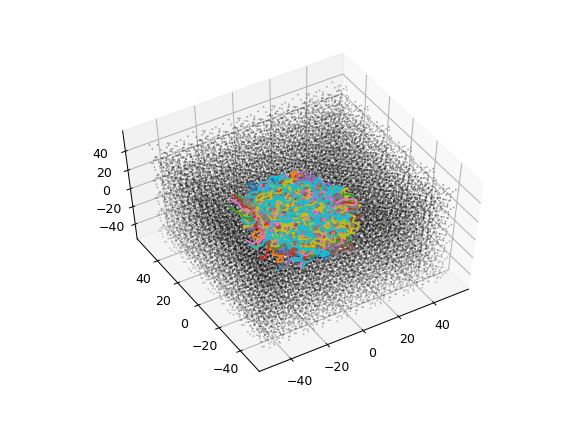

In [137]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(0,20):
    x = []
    y = []
    z = []
    
    d_rot = solv.random_rotation()
    
    for k,v in d_rot.items():
        coord = v['CA']
        x.append(coord[0])
        y.append(coord[1])
        z.append(coord[2])
    
    ax.plot(x,y,z)
    
ax.scatter(wat_x, wat_y, wat_z, marker='.', s=0.2, color='k')
    
plt.show()

In [35]:
for i in range(0,20):
    print(i)
    d_rot = solv.random_rotation()
    wat = solv.remove_clash_waters(d_rot)
    print(len(wat))
    

0
7516
1
7514
2
7515
3
7515
4
7513
5
7515
6
7515
7
7514
8
7516
9
7514
10
7513
11
7515
12
7515
13
7515
14
7514
15
7515
16
7515
17


KeyboardInterrupt: 

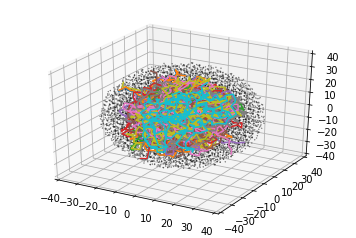

In [261]:
wat = solv.trim_box()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(0,20):
    x = []
    y = []
    z = []
    
    d_rot = solv.random_rotation()
    
    for k,v in d_rot.items():
        coord = v['CA']
        x.append(coord[0])
        y.append(coord[1])
        z.append(coord[2])
    
    ax.plot(x,y,z)

ax.scatter(wat[:,0],wat[:,1],wat[:,2],marker='.',s=0.5, color='k')
plt.show()

In [267]:
a = np.array([[1,2,3],[4,5,6]])
b = [7,8,9]
np.linalg.norm(a-b,axis=-1)

array([10.39230485,  5.19615242])

In [252]:
d_rot

{'A:36': {'N': [-23.492, 26.205032959042548, 7.466523998186421],
  'CA': [-23.104000000000003, 25.255268673179835, 6.438790666383035],
  'C': [-22.553, 25.889839798293792, 5.171686689918751],
  'O': [-22.55, 27.11745709264052, 5.054431504017097]},
 'A:37': {'N': [-22.084000000000003, 25.03829910366512, 4.2445969178948575],
  'CA': [-21.606, 25.39821225084321, 2.9041240436865197],
  'CB': [-20.662000000000003, 26.618645226160815, 2.952459876744493],
  'CG': [-20.05, 27.341621103388714, 1.7333725620100005],
  'CD1': [-18.907, 26.585152866887675, 1.0547203630413282],
  'CD2': [-21.146, 27.68884796467633, 0.7226087385574846],
  'C': [-20.886000000000003, 24.201660769968385, 2.2713819527708967],
  'O': [-20.006, 24.387976963723194, 1.421713619864037]},
 'A:38': {'N': [-21.257, 22.97164580347572, 2.6588134721443817],
  'CA': [-20.424000000000003, 21.787173544602364, 2.445845239866763],
  'CB': [-20.079, 21.10824060024691, 3.784482628060008],
  'CG': [-18.972, 21.8237521084162, 4.526337251067

In [271]:
print(squareform(pdist(wat)))

[[ 0.          2.8071872  13.46984339 ... 69.3711198  72.4591521
  71.72046209]
 [ 2.8071872   0.         11.3186095  ... 71.15444274 73.71807325
  72.9047439 ]
 [13.46984339 11.3186095   0.         ... 74.41358077 74.4544074
  73.56026102]
 ...
 [69.3711198  71.15444274 74.41358077 ...  0.         17.34748976
  18.621     ]
 [72.4591521  73.71807325 74.4544074  ... 17.34748976  0.
   2.98989966]
 [71.72046209 72.9047439  73.56026102 ... 18.621       2.98989966
   0.        ]]


In [19]:
d_rot = solv.random_rotation()
start = time.time()
wat = solv.remove_clash_waters2(d_rot)
end = time.time()
print(end - start)

0.8120419979095459


In [329]:
len(wat)

15533626

<IPython.core.display.Javascript object>


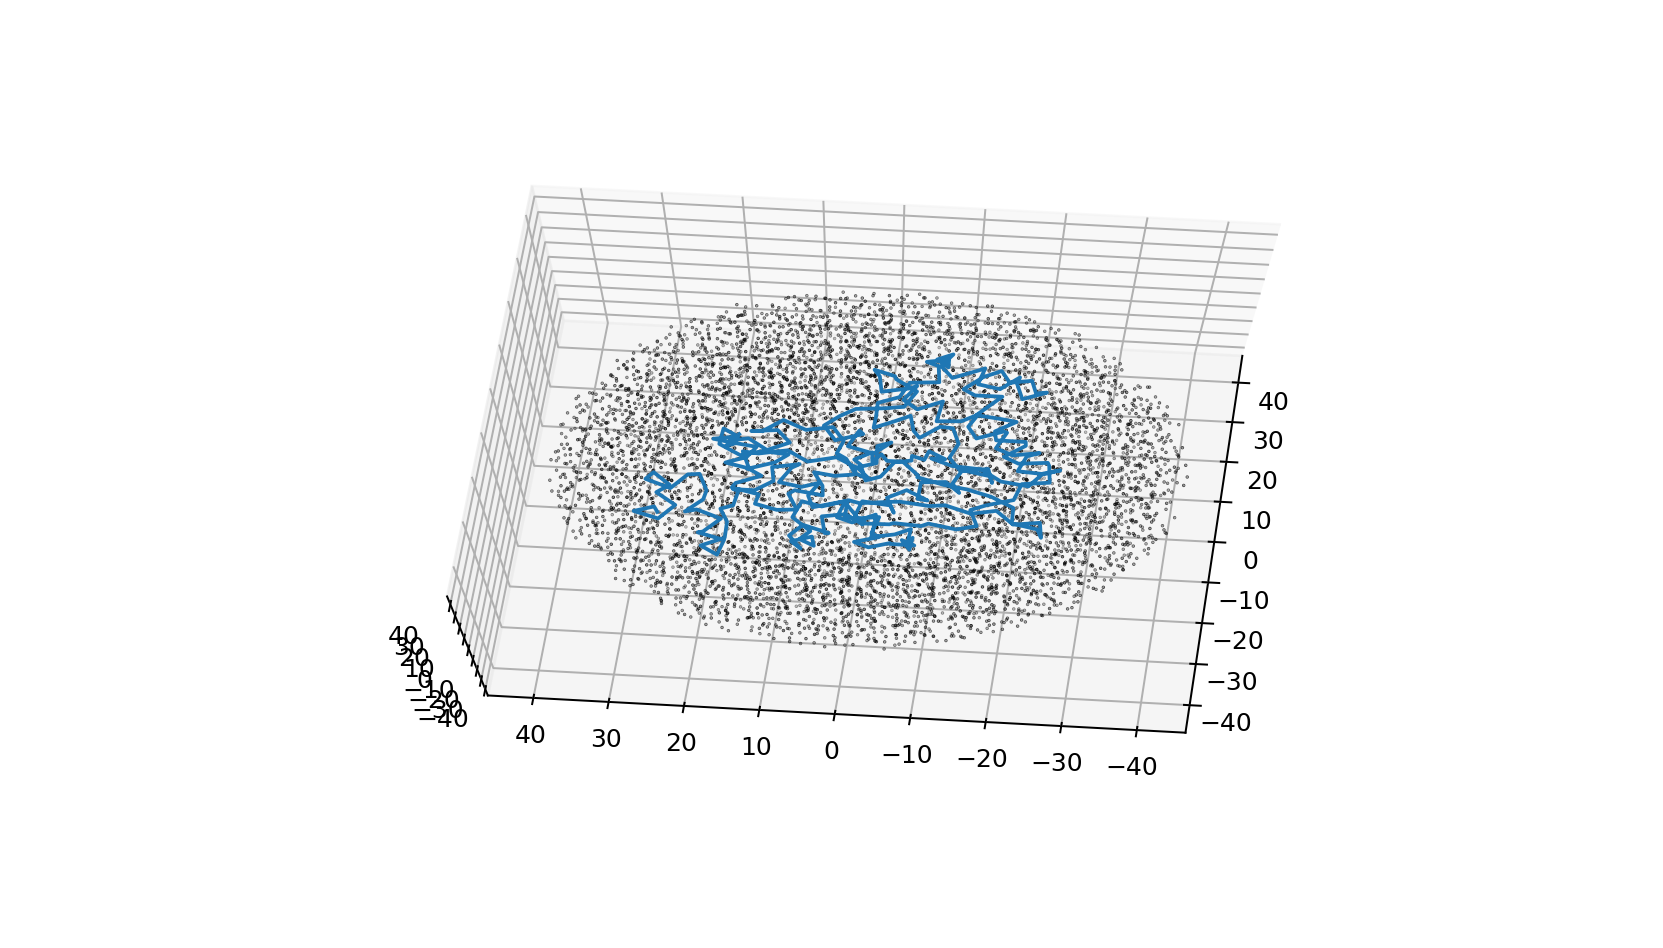

In [63]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = []
y = []
z = []

# d_rot = solv.random_rotation()

for k,v in d_rot.items():
    coord = v['CA']
    x.append(coord[0])
    y.append(coord[1])
    z.append(coord[2])

ax.plot(x,y,z)

watx = []
waty = []
watz = []

for w in bulk_wat:
    watx.append(w[0])
    waty.append(w[1])
    watz.append(w[2])

ax.scatter(watx,waty,watz,marker='.',s=0.5, color='k')
plt.show()

In [14]:
start_tot = time.time()
solv = Solvate("native.pdb",neighbours=2)
pdb = solv.pdb_file
water = solv.water_box


# trans_pdb = solv.translate_coords(pdb[0],pdb[1])
d_rot = solv.random_rotation()
start = time.time()
wat = solv.remove_clash_waters(d_rot)
bulk_wat = solv.remove_bulk_water(wat)
end = time.time()
print("Water removed in: %s" % str(end-start))
start = time.time()
dists = solv.get_distances(d_rot,bulk_wat)
res_depths = solv.get_res_distances(dists)
end = time.time()
print("Distances calculated in: %s" % str(end - start))
end_tot = time.time()

print("Total time: %s" % str(end_tot-start_tot))

<ipython-input-13-05259c67f8ba>:157: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "remove_clash_waters_process" failed type inference due to: non-precise type pyobject
[1] During: typing of argument at <ipython-input-13-05259c67f8ba> (160)

File "<ipython-input-13-05259c67f8ba>", line 160:
    def remove_clash_waters_process(self,w):
        <source elided>
#         #print(w)
        for a in self.atoms:
        ^

  @jit
<ipython-input-13-05259c67f8ba>:157: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "remove_clash_waters_process" failed type inference due to: cannot determine Numba type of <class 'numba.dispatcher.LiftedLoop'>

File "<ipython-input-13-05259c67f8ba>", line 160:
    def remove_clash_waters_process(self,w):
        <source elided>
#         #print(w)
        for a in self.atoms:
        ^

  @jit
/Users/sm002/anaconda2/lib/python3.6/site-packages/numba/objec

<ipython-input-13-05259c67f8ba>:157: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "remove_clash_waters_process" failed type inference due to: non-precise type pyobject
[1] During: typing of argument at <ipython-input-13-05259c67f8ba> (160)

File "<ipython-input-13-05259c67f8ba>", line 160:
    def remove_clash_waters_process(self,w):
        <source elided>
#         #print(w)
        for a in self.atoms:
        ^

  @jit
<ipython-input-13-05259c67f8ba>:157: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "remove_clash_waters_process" failed type inference due to: cannot determine Numba type of <class 'numba.dispatcher.LiftedLoop'>

File "<ipython-input-13-05259c67f8ba>", line 160:
    def remove_clash_waters_process(self,w):
        <source elided>
#         #print(w)
        for a in self.atoms:
        ^

  @jit
<ipython-input-13-05259c67f8ba>:157: NumbaWarning: 
Compilatio

Water removed in: 52.84944009780884


<ipython-input-13-05259c67f8ba>:250: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "get_distances_process" failed type inference due to: non-precise type pyobject
[1] During: typing of argument at <ipython-input-13-05259c67f8ba> (252)

File "<ipython-input-13-05259c67f8ba>", line 252:
    def get_distances_process(self,k,v,k1,v1,water):
        x = 0
        ^

  @jit
<ipython-input-13-05259c67f8ba>:250: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "get_distances_process" failed type inference due to: cannot determine Numba type of <class 'numba.dispatcher.LiftedLoop'>

File "<ipython-input-13-05259c67f8ba>", line 253:
    def get_distances_process(self,k,v,k1,v1,water):
        <source elided>
        x = 0
        for w in water:
        ^

  @jit
/Users/sm002/anaconda2/lib/python3.6/site-packages/numba/object_mode_passes.py:178: NumbaWarning: Function "get_distances_proces

/Users/sm002/anaconda2/lib/python3.6/site-packages/numba/object_mode_passes.py:178: NumbaWarning: Function "get_distances_process" was compiled in object mode without forceobj=True, but has lifted loops.

File "<ipython-input-13-05259c67f8ba>", line 252:
    def get_distances_process(self,k,v,k1,v1,water):
        x = 0
        ^

  state.func_ir.loc))
/Users/sm002/anaconda2/lib/python3.6/site-packages/numba/object_mode_passes.py:188: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "<ipython-input-13-05259c67f8ba>", line 252:
    def get_distances_process(self,k,v,k1,v1,water):
        x = 0
        ^

  state.func_ir.loc))
/Users/sm002/anaconda2/lib/python3.6/site-packages/numba/object_mode_passes.py:178: NumbaWarning

Distances calculated in: 42.2348108291626
Total time: 95.83467483520508


In [72]:
print(len(wat), len(bulk_wat))


5866 5678


In [4]:
dists

{'A:36': {'N': 3.111716829875743,
  'CA': 2.9851780466765856,
  'C': 3.573999323274873,
  'O': 2.890498966594868},
 'A:37': {'N': 3.3842543397116827,
  'CA': 3.09217900000822,
  'CB': 3.4828536754206794,
  'CG': 3.5159032029485107,
  'CD1': 2.742133838467126,
  'CD2': 3.499955149821192,
  'C': 2.888670856726919,
  'O': 3.055793332514623},
 'A:38': {'N': 3.389648764331552,
  'CA': 3.800878044406993,
  'CB': 3.257157047838469,
  'CG': 3.0198708315963003,
  'OD1': 2.9640660345473755,
  'OD2': 2.6269785826004735,
  'C': 3.25907370276419,
  'O': 2.6626691813665753},
 'A:39': {'N': 4.119629374600035,
  'CA': 4.075178225200953,
  'CB': 3.0943976527313577,
  'CG1': 3.1386052125044994,
  'CG2': 3.9830789094708328,
  'CD1': 2.659143556277987,
  'C': 4.458045055566257,
  'O': 4.117667873404821},
 'A:40': {'N': 4.201811273878244,
  'CA': 4.797211999043412,
  'CB': 4.127510135013919,
  'CG': 3.2358785485961294,
  'CD1': 2.671432340158905,
  'CD2': 3.5313604760860344,
  'C': 5.8926518956608325,
  'O

In [7]:
gt = {}

with open('native-atom.depth') as f:
    g = f.read().splitlines()
    for line in g[1:]:
        if line.split()[1] not in gt.keys():
            gt[line.split()[1]] = {line.split()[2]:float(line.split()[3])}
        else:
            gt[line.split()[1]][line.split()[2]] = float(line.split()[3])
    f.close()

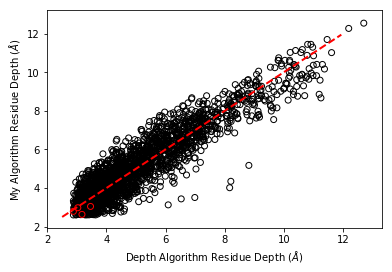

In [265]:
gt_list = []
my_list = []

line = np.arange(2.5,12,0.05)

for k in gt:
    for k2 in gt[k]:
        plt.scatter(gt[k][k2],dists[k][k2],facecolor='none',edgecolor='k')
        gt_list.append(gt[k][k2])
        my_list.append(dists[k][k2])
for k2 in gt['A:36']:
    plt.scatter(gt['A:36'][k2],dists['A:36'][k2],facecolor='none',edgecolor='r')
plt.plot(line,line,color='r',linestyle='--',linewidth=2)

plt.xlabel(r"Depth Algorithm Residue Depth ($\AA$)")
plt.ylabel(r"My Algorithm Residue Depth ($\AA$)")

plt.show()

In [54]:
def my_decorator(func):
    def wrapper():
        print("Something is happening before the function is called.")
        func()
        print("Something is happening after the function is called.")
    return wrapper

@my_decorator
def say_whee():
    print("Whee!")

In [56]:
say_whee()

Something is happening before the function is called.
Whee!
Something is happening after the function is called.


In [167]:
sts.spearmanr(gt_list,my_list)

SpearmanrResult(correlation=0.8737067918087741, pvalue=0.0)

In [88]:
os.cpu_count()

4

In [110]:
wat

[]

In [109]:
solv.water_no_clash

[]

In [10]:
start_tot = time.time()
solv = Solvate("native.pdb",neighbours=2)
pdb = solv.pdb_file
water = solv.water_box


# trans_pdb = solv.translate_coords(pdb[0],pdb[1])
start_tot = time.time()
def run_iteration():
    d_rot = solv.random_rotation()
    start = time.time()
    wat = solv.remove_clash_waters(d_rot)
    bulk_wat = solv.remove_bulk_water(wat)
    end = time.time()
    print("Water removed in: %s" % str(end-start))
    start = time.time()
    dists = solv.get_distances(d_rot,bulk_wat)
    res_depths = solv.get_res_distances(dists)
    end = time.time()
    print("Distances calculated in: %s" % str(end - start))
    end_tot = time.time()

    print("Total time: %s\n" % str(end_tot-start_tot))
    
    return dists

In [9]:
start_tot = time.time()
run_iteration()

NotDefinedError: Failed in object mode pipeline (step: analyzing bytecode)
[1mVariable 'self' is not defined.
[1m
File "<ipython-input-2-b3686af1cec6>", line 177:[0m
[1m    def remove_clash_waters(self, coords):
        <source elided>
        """
[1m        water_clash = self.trim_box().tolist()
[0m        [1m^[0m[0m
[0m

Unsupported Python functionality was found in the code Numba was trying to
compile. This error could be due to invalid code, does the code work
without Numba? (To temporarily disable Numba JIT, set the `NUMBA_DISABLE_JIT`
environment variable to non-zero, and then rerun the code).

If the code is valid and the unsupported functionality is important to you
please file a feature request at: https://github.com/numba/numba/issues/new

To see Python/NumPy features supported by the latest release of Numba visit:
http://numba.pydata.org/numba-doc/latest/reference/pysupported.html
and
http://numba.pydata.org/numba-doc/latest/reference/numpysupported.html


In [257]:
d_mean = {}

for k in runs[0].keys():
    for k1 in runs[0][k]:
        atom = []
        for r in runs:
            atom.append(r[k][k1])
        mean_atom = np.mean(atom)
        
        if k not in d_mean.keys():
            d_mean[k] = {k1:mean_atom}
        else:
            d_mean[k][k1] = mean_atom

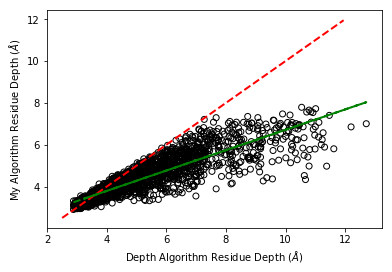

In [258]:
gt_list = []
my_list = []

line = np.arange(2.5,12,0.05)

for k in gt:
    for k2 in gt[k]:
#         plt.scatter(gt[k][k2],d_mean[k][k2],facecolor='none',edgecolor='k')
        gt_list.append(gt[k][k2])
        my_list.append(d_mean[k][k2])
plt.scatter(gt_list,my_list,facecolor='none',edgecolor='k')
# for k2 in gt['A:36']:
#     plt.scatter(gt['A:36'][k2],dists['A:36'][k2],facecolor='none',edgecolor='r')

plt.plot(line,line,color='r',linestyle='--',linewidth=2)

coef = np.polyfit(gt_list,my_list,1)
# print(coef)
poly1d_fn = np.poly1d(coef)

plt.plot(gt_list, poly1d_fn(gt_list), linestyle='--',color='g',linewidth=2)

plt.xlabel(r"Depth Algorithm Residue Depth ($\AA$)")
plt.ylabel(r"My Algorithm Residue Depth ($\AA$)")
plt.show()

In [166]:
run_length = ((1893.7087302207947 - 139.61013293266296) + (57.46991014480591 + 40.61900997161865))/60
run_length

30.869791956742606

In [178]:
sts.spearmanr(gt_list,my_list)

SpearmanrResult(correlation=0.8737067918087741, pvalue=0.0)

In [179]:
solv.water_no_clash

[]

[0.50395397 1.81250734]
[0.5422524  1.60965492]
[0.49553085 1.78776581]
[0.57570602 1.46384085]
[0.40079394 2.1967182 ]
[0.49413577 1.7748673 ]
[0.40631264 2.24300494]
[0.42134484 2.07357885]
[0.52144075 1.68971055]
[0.49711251 1.81085993]
[0.51602627 1.7196854 ]
[0.48317752 1.90235354]
[0.5091379  1.77610929]
[0.50814054 1.73480245]
[0.55292299 1.58820662]
[0.4890431  1.87675911]
[0.45328738 1.90835143]
[0.52475217 1.66870354]
[0.42795749 2.06632952]
[0.41205144 2.20463505]


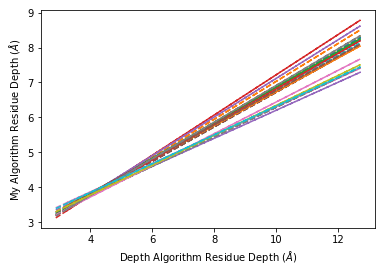

In [259]:
coefs = []
for run in runs:
    gt_list = []
    my_list = []

    line = np.arange(2.5,12,0.05)

    for k in gt:
        for k2 in gt[k]:
    #         plt.scatter(gt[k][k2],d_mean[k][k2],facecolor='none',edgecolor='k')
            gt_list.append(gt[k][k2])
            my_list.append(run[k][k2])
    # for k2 in gt['A:36']:
    #     plt.scatter(gt['A:36'][k2],dists['A:36'][k2],facecolor='none',edgecolor='r')
#     plt.scatter(gt_list,my_list,facecolor='none',edgecolor='k')
#     plt.plot(line,line,color='r',linestyle='--',linewidth=2)

    coef = np.polyfit(gt_list,my_list,1)
    coefs.append(coef.tolist()[1])
    print(coef)
    poly1d_fn = np.poly1d(coef)
    
    
    plt.plot(gt_list, poly1d_fn(gt_list), linestyle='--')

plt.xlabel(r"Depth Algorithm Residue Depth ($\AA$)")
plt.ylabel(r"My Algorithm Residue Depth ($\AA$)")
plt.show()

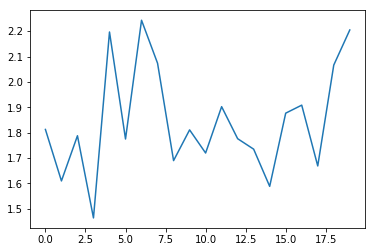

In [260]:
plt.plot(np.arange(len(coefs)),coefs)
plt.show()

In [238]:
coefs

[2.1593518360955084,
 1.4674657386603427,
 1.9500282049818656,
 1.5713308382326228,
 1.5669109034860869,
 1.6636455282353293,
 2.229585784577757,
 2.1137245506163986,
 2.074528133282678,
 1.7592718828333778,
 1.8196191107193074,
 1.964411025203125,
 1.7553841887323474,
 1.679943105004002,
 1.9372989675456533,
 2.307185195928086,
 1.8225010849927574,
 1.8108666986564295,
 1.7626521621145057,
 1.686355864894494]

In [245]:
trans_pdb

{'A:36': {'N': [-23.492, -3.003, -27.082],
  'CA': [-23.104, -3.595, -25.814],
  'C': [-22.553, -5.008, -25.922],
  'O': [-22.55, -5.581, -27.014]},
 'A:37': {'N': [-22.084, -5.544, -24.783],
  'CA': [-21.606, -6.921, -24.609],
  'CB': [-20.662, -7.338, -25.757],
  'CG': [-20.05, -8.74, -25.965],
  'CD1': [-18.907, -9.082, -25.008],
  'CD2': [-21.146, -9.807, -25.904],
  'C': [-20.886, -7.054, -23.262],
  'O': [-20.006, -7.911, -23.113]},
 'A:38': {'N': [-21.257, -6.23, -22.27],
  'CA': [-20.424, -5.979, -21.093],
  'CB': [-20.079, -4.483, -20.971],
  'CG': [-18.972, -4.067, -21.914],
  'OD1': [-17.949, -4.785, -21.971],
  'OD2': [-19.117, -3.023, -22.59],
  'C': [-21.058, -6.439, -19.779],
  'O': [-22.284, -6.484, -19.623]},
 'A:39': {'N': [-20.18, -6.775, -18.827],
  'CA': [-20.529, -6.931, -17.417],
  'CB': [-20.267, -8.375, -16.929],
  'CG1': [-20.944, -8.66, -15.562],
  'CG2': [-18.757, -8.709, -16.954],
  'CD1': [-22.363, -8.104, -15.416],
  'C': [-19.729, -5.876, -16.651],
  'O'

In [254]:
solv.pdb_file[1]

(0, 0, 0)

In [5]:
server_run = {}

with open("results.txt") as f:
    g = f.read().splitlines()
    for line in g[1:]:
        k = line.split()[0]
        k1 = line.split()[1]
        depth = float(line.split()[2])
        if k not in server_run:
            server_run[k] = {k1:depth}
        else:
            server_run[k][k1] = depth

<IPython.core.display.Javascript object>


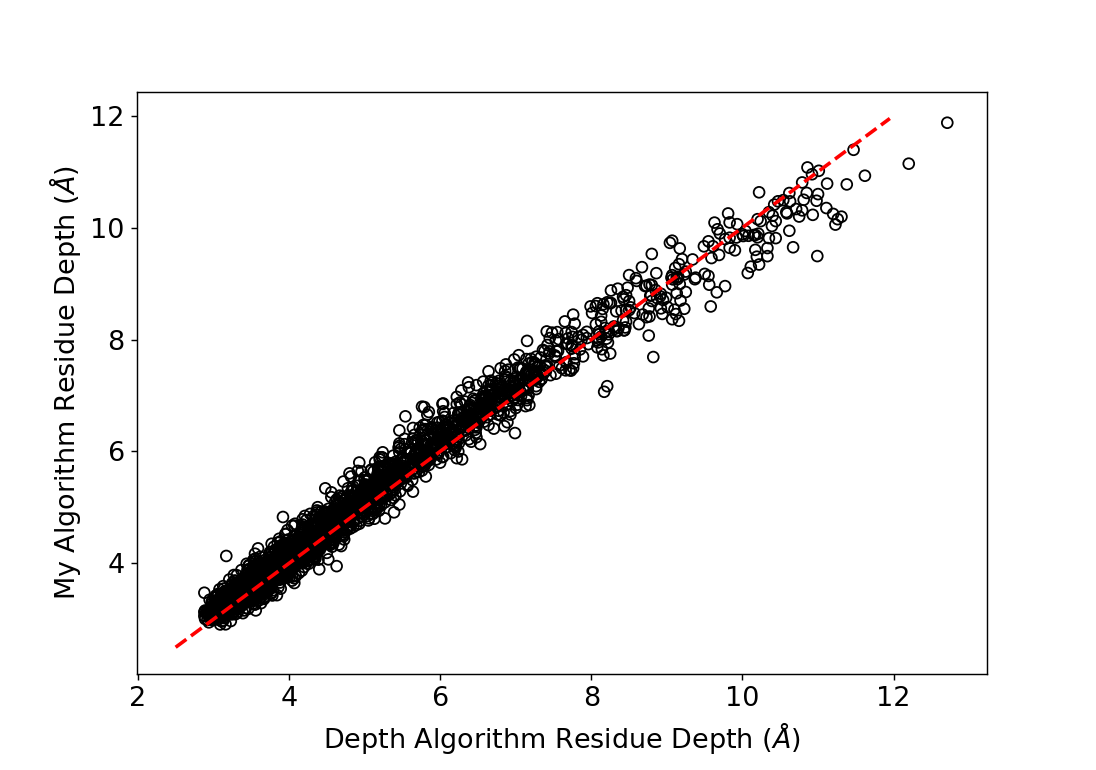

In [24]:
gt_list = []
my_list = []

line = np.arange(2.5,12,0.05)

for k in gt:
    for k2 in gt[k]:
#         plt.scatter(gt[k][k2],d_mean[k][k2],facecolor='none',edgecolor='k')
        gt_list.append(gt[k][k2])
        my_list.append(server_run[k][k2])
plt.scatter(gt_list,my_list,facecolor='none',edgecolor='k')
# for k2 in gt['A:36']:
#     plt.scatter(gt['A:36'][k2],dists['A:36'][k2],facecolor='none',edgecolor='r')

plt.plot(line,line,color='r',linestyle='--',linewidth=2)

coef = np.polyfit(gt_list,my_list,1)
# print(coef)
poly1d_fn = np.poly1d(coef)

# plt.plot(gt_list, poly1d_fn(gt_list), linestyle='--',color='g',linewidth=2)

plt.xlabel(r"Depth Algorithm Residue Depth ($\AA$)")
plt.ylabel(r"My Algorithm Residue Depth ($\AA$)")
plt.show()

In [17]:
all_mean, all_std, mc_mean, mc_std, sc_mean, sc_std, sc_pol_mean, sc_pol_std, sc_nopol_mean,sc_nopol_std = res_depths

In [18]:
all_mean

{'A:36': 3.381167788669737,
 'A:37': 3.2167364366494633,
 'A:38': 3.411358340133704,
 'A:39': 3.6909252347554324,
 'A:40': 4.23340856745699,
 'A:41': 5.0871423708776184,
 'A:42': 6.124713820594276,
 'A:43': 4.386014732053024,
 'A:44': 4.255354187193258,
 'A:45': 4.249870339030047,
 'A:46': 4.266589866126629,
 'A:47': 3.4445592341558373,
 'A:48': 4.84005855217348,
 'A:49': 3.5833295101933484,
 'A:50': 5.8227668384313915,
 'A:51': 7.050463156116914,
 'A:52': 5.968882653759937,
 'A:53': 9.2867651538317,
 'A:54': 5.5328946245618695,
 'A:55': 4.657765525175943,
 'A:56': 8.822191819709806,
 'A:57': 7.678901387226165,
 'A:58': 4.788630312602159,
 'A:59': 8.058206601148505,
 'A:60': 5.248538089155212,
 'A:61': 4.409578884864876,
 'A:62': 6.95210860546494,
 'A:63': 7.547453415994598,
 'A:64': 6.288872728293401,
 'A:65': 5.690273147323426,
 'A:66': 5.895102496088773,
 'A:67': 6.170382572559674,
 'A:68': 5.609119311018897,
 'A:69': 5.601761095931355,
 'A:70': 4.4675143699514015,
 'A:71': 3.488862

In [20]:
np.std([54])

0.0

In [23]:
font = {'family' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)

<IPython.core.display.Javascript object>


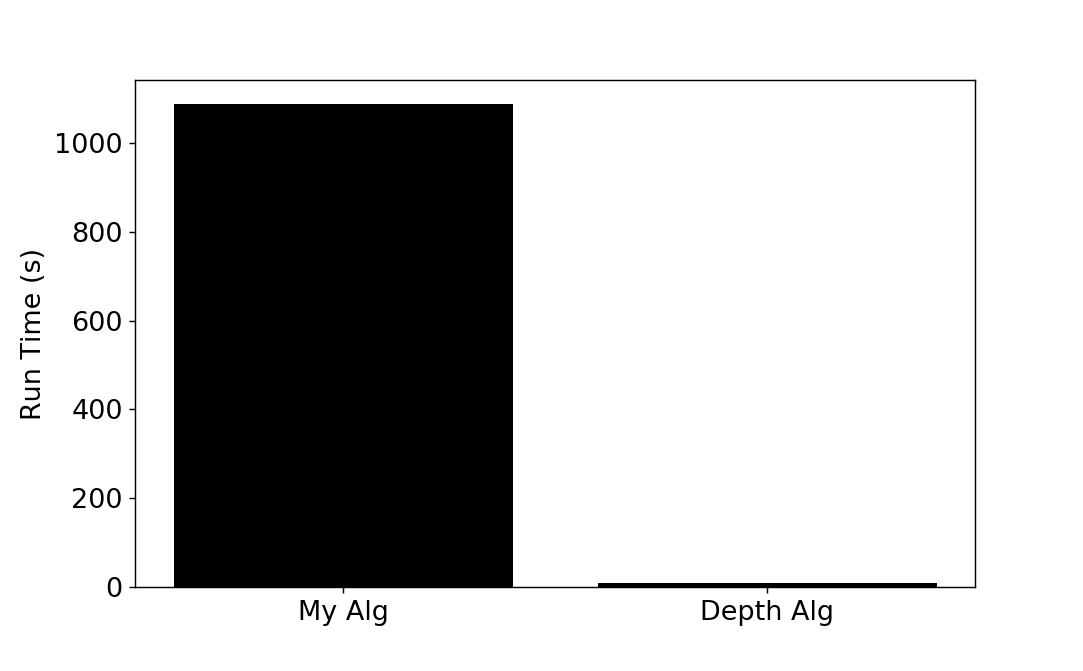

In [27]:
my_alg_time = 1086.725
dp_alg_time = 8.322

plt.bar([1,2],[my_alg_time,dp_alg_time],color='k')
plt.xticks([1,2],['My Alg','Depth Alg'])
plt.ylabel('Run Time (s)')
plt.show()

In [29]:
my_alg_time/dp_alg_time

130.584595049267